# Skin disease recognition

Dermatology is one of the most neglected areas when it comes to preventing and maintaining human health. Many people do not pay attention to changes that occur on their skin, often treating them as something harmless that they have become accustomed to, putting a visit to a specialist at the bottom of their priority list. These growths, when left untreated, can remain dormant for a long time and then, for example, after exposure to an external factor, can take on a pathological form that significantly threatens our health.

In recent years, due to technological advances, modern computer tools have been increasingly used in the diagnosis of skin diseases. One of these tools is neural networks, which are excellent at detecting patterns in images for classification purposes. This allows for the early detection of potentially dangerous skin changes and faster medical intervention. The development of technology in image recognition enables the creation of increasingly advanced systems that can help diagnose skin diseases and improve the health of patients. This paper presents the process of recognizing skin changes based on photographs and evaluates the effectiveness of machine learning algorithms in this task.

Data comes from:
*Tschandl P., Rosendahl C. & Kittler H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 doi:10.1038/sdata.2018.161 (2018)*

<img src="img/dermatolog.jpg" alt="Dermatologist" width="700">

# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data gathering

### Dataset description
The dataset consists of following columns:
 - *lesion_id* - id number of particular lesion
 - *image_id* - image file name
 - *dx* - recognized lesion code, which stands for:
    - *akiec* - Actinic keratoses and intraepithelial carcinoma / Bowen's disease
    - *bcc* - basal cell carcinoma
    - *bkl* - benign keratosis-like lesions
    - *df* - dermatofibroma
    - *mel* - melanoma
    - *nv* - melanocytic nevi
    - *vasc* - vascular lesions

 - *dx_type* - defines how was the lesion was recognized:
    - *histo* - through histopathology
    - *follow-up* - follow-up examination
    - *consensus* - expert consensus
    - *confocal* - confirmation by in-vivo confocal microscopy
 - *age* - patient's age group
 - *sex* - patient's sex
 - *localization* - localization of the lesion


### Loading images metadata
Read the file with recognized lesions data

In [2]:
lesions_df = pd.read_csv('archive/HAM10000_metadata.csv')
lesions_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Loading images
I will load the images using data generator object. A data generator is an object in TensorFlow that enables easy loading of large datasets, such as images, into memory one batch at a time. In the case of large datasets, such as image datasets, loading them all at once into memory can lead to the exhaustion of memory resources, as well as prolong the time it takes to load the data.

To properly connect labels from the dataframe with photos we need to pass correct filename, which mean we must modify the *image_id* column:

In [3]:
lesions_df['image_id'] = lesions_df['image_id'] + '.jpg'
lesions_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear


For proper training/validation data split I will shuffle the dataset, so that all classes are more-less evenly distributed in those subsets.

In [4]:
lesions_df = lesions_df.sample(frac=1)

Now I can create the generator:

In [5]:
# Creating ImageDataGenerator object
img_generator = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=180
                                   )

### Splitting the data into training, validation and test sets

In [6]:
# First data split
lesions_train_df, lesions_test_df = train_test_split(lesions_df, test_size=0.1)
# Second split
lesions_train_df, lesions_valid_df = train_test_split(lesions_train_df, test_size=0.2)
print(f'Training data: {len(lesions_train_df)} elements')
print(f'Validation data: {len(lesions_valid_df)} elements')
print(f'Testing data: {len(lesions_test_df)} elements')

Training data: 7210 elements
Validation data: 1803 elements
Testing data: 1002 elements


Now create generators

In [7]:
# Images directory
img_dir = 'archive/HAM10000_images'
# Training data generator
train_generator = img_generator.flow_from_dataframe(dataframe=lesions_train_df,  # DataFrame with labels
                                                    directory=img_dir,  # images directory
                                                    x_col='image_id',  # column name containing images names
                                                    y_col='dx',  # column name containing labels
                                                    class_mode='categorical',  # classification mode
                                                    batch_size=32)
# Validation data generator
validation_generator = img_generator.flow_from_dataframe(dataframe=lesions_valid_df,
                                                         directory=img_dir,
                                                         x_col='image_id',
                                                         y_col='dx',
                                                         class_mode='categorical',
                                                         batch_size=32)
# Testing data generator
test_generator = img_generator.flow_from_dataframe(dataframe=lesions_test_df,
                                                    directory=img_dir,
                                                    x_col='image_id',
                                                    y_col='dx',
                                                    class_mode='categorical',
                                                    batch_size=32)

Found 7210 validated image filenames belonging to 7 classes.
Found 1803 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.


### Check how the data has been split
We have to check if the data has been spit evenly into both - training and testing - sets.

In [8]:
# Counts values
index_train, counts_train = np.unique(train_generator.classes, return_counts=True)
index_valid, counts_valid = np.unique(validation_generator.classes, return_counts=True)
index_test, counts_test = np.unique(test_generator.classes, return_counts=True)
# Create DataFrame
split_counts_df = pd.DataFrame(index=train_generator.class_indices.keys())
split_counts_df['Training'] = counts_train
split_counts_df['Validation'] = counts_valid
split_counts_df['Testing'] = counts_test
# Show the DataFrame
split_counts_df

,Training,Validation,Testing
akiec,227,60,40
bcc,376,85,53
bkl,777,186,136
df,85,20,10
mel,785,207,121
nv,4858,1223,624
vasc,102,22,18


Now let's show it on the plot

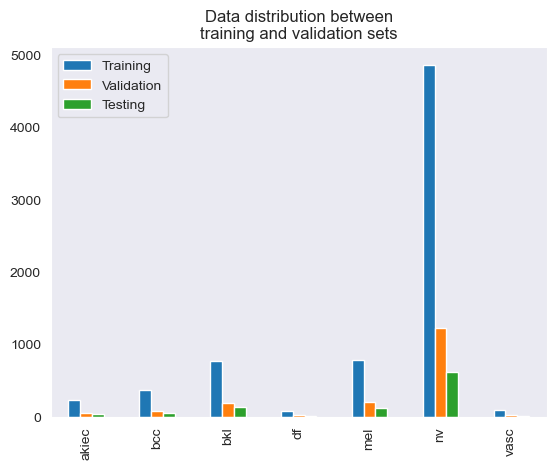

In [9]:
ax = split_counts_df.plot.bar()
ax.grid(False)
ax.set_title('Data distribution between\ntraining and validation sets')

plt.show()

**Conclusion:** The data has been split evenly, so in both datasets there will be similar samples distribution.

# Exploratory data analysis
Let's have a look at how the diseases are distributed

### Lession types count
Let's check how many lesions of each category are in the dataset. I will split it into two charts, where one will show distribution of distinct lesions shown in the dataset and the other will show distribution of lesions images, because some lesions have couple photos. To do it I will prepare the second dataset for them.

In [10]:
distinct_lesions_df = lesions_df.drop('image_id', axis=1).drop_duplicates()
distinct_lesions_df.head()

,lesion_id,dx,dx_type,age,sex,localization
8089,HAM_0003667,nv,histo,10.0,male,chest
6755,HAM_0001869,nv,histo,55.0,female,hand
3880,HAM_0007109,nv,follow_up,55.0,male,abdomen
6311,HAM_0000369,nv,follow_up,55.0,female,upper extremity
6490,HAM_0006552,nv,follow_up,65.0,male,trunk


Next I will prepare a DataFrame to store both counted values

In [11]:
counts_df = pd.DataFrame()
counts_df['images_count'] = lesions_df['dx'].value_counts()
counts_df['lesions_count'] = distinct_lesions_df['dx'].value_counts()
counts_df

,images_count,lesions_count
nv,6705,5403
mel,1113,616
bkl,1099,727
bcc,514,327
akiec,327,228
vasc,142,98
df,115,73


...and create a plot

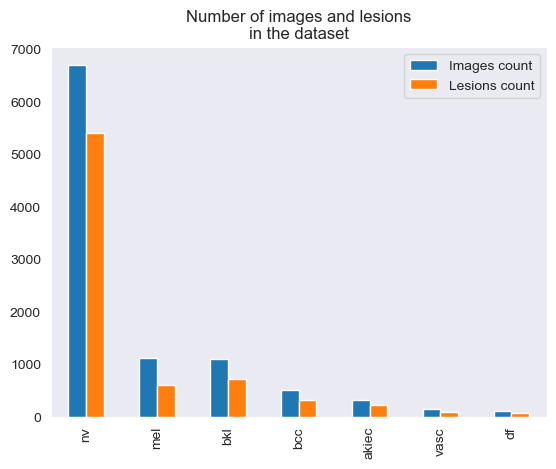

In [12]:
ax = counts_df.plot.bar()
ax.legend(labels=['Images count', 'Lesions count'])
ax.set_title('Number of images and lesions\nin the dataset')
ax.grid(False)
plt.show()

### Density plot for each lesion type vs age
Let's check how do the particular diseases appear in several age groups - this will be shown on density plot.

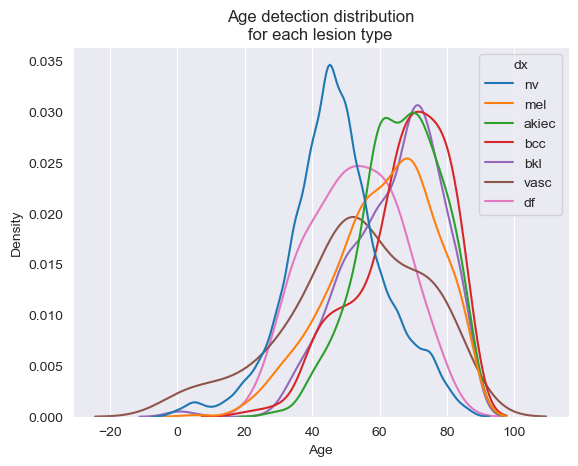

In [13]:
ax = sns.kdeplot(
    data=distinct_lesions_df,
    x='age',
    common_norm=False,
    hue='dx'
)
ax.set_title('Age detection distribution\nfor each lesion type')
ax.grid(axis='y', visible=False)
ax.set_xlabel('Age')

plt.show()

**Conclusion:** People at their forties should start to take care of melanocytic nevi disease (*nv*), while when reaching age of 50 dermatofibroma (*df*) and vascular lesions (*vasc*) most usually appear. The rest of diseases the most intensively appear after age of 60.

# Building model

### Model architecture
Below the model architecture is defined. It uses a series of convolutional layers with increasing numbers of filters (32, 64, and 128), followed by max pooling layers to downsample the feature maps. The use of multiple convolutional layers allows the network to learn increasingly complex features from the images, while the max pooling layers reduce the spatial dimensions of the feature maps, allowing the network to focus on the most important features. The final dense layers use a softmax activation function to produce probability scores for each class. Additionally, the architecture includes a flatten layer that converts the 2D feature maps to a 1D feature vector, which is necessary for passing the features to the dense layers.

In [14]:
model = keras.Sequential([layers.Conv2D(32, (3, 3), activation='relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Conv2D(64, (3, 3), activation='relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Conv2D(128, (3, 3), activation='relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Flatten(),
                          layers.Dense(128, activation='relu'),
                          layers.Dense(7, activation='softmax')
])

In [15]:
model_2 = keras.Sequential([layers.Conv2D(32, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(64, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(128, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Flatten(),
                            layers.Dropout(0.25),
                            layers.Dense(128, activation='relu'),
                            layers.Dense(7, activation='softmax')
])

In [82]:
model_3 = keras.Sequential([layers.Conv2D(16, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(32, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(64, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(128, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Flatten(),
                            layers.Dense(128, activation='relu'),
                            layers.Dense(7, activation='softmax')
])

### Model class weights
As one class outnumbers others I will add weights to the classes to equalize their input to the loss function. This tells the algorithm to "pay more attention" to samples from an under-represented class.

In [49]:
# Get classes to predict during training
classes_train = train_generator.classes
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(classes_train), y=classes_train)
# Print it
class_weights_dict = dict(zip(range(7), class_weights))
for key in class_weights_dict:
    print(f'{key} -> {class_weights_dict[key]}')

0 -> 4.537444933920705
1 -> 2.7393617021276597
2 -> 1.3256113256113256
3 -> 12.117647058823529
4 -> 1.3121019108280254
5 -> 0.21202140798682587
6 -> 10.098039215686274


We can see that class with index 5, which outnumbers other classes has the lowest weight.

### Model class weights - manual version
Below I am setting manually classes weights, only to limit the impact of the most numerous class and to strengthen two the rarest ones.

In [50]:
class_weights_manual = dict()
for i in range(6):
    class_weights_manual[i] = 1

class_weights_manual[3] = 2
class_weights_manual[5] = 0.5
class_weights_manual[6] = 2

for key in class_weights_manual:
    print(f'{key} -> {class_weights_manual[key]}')

0 -> 1
1 -> 1
2 -> 1
3 -> 2
4 -> 1
5 -> 0.5
6 -> 2


### Model compilation
Model compilation is responsible for configuring it for training by specifying the optimizer, loss function, and metrics to be used during the training process. The optimizer determines how the model is updated based on the loss function and gradients calculated during training, while the loss function is used to measure the error between the predicted output and the actual output. Metrics are used to evaluate the performance of the model during training and can be used to monitor the progress of the training process.

optional TODO: choose parameters for non-even data distribution as 'accuracy' is good for evenly distributed classes

In [70]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

In [71]:
model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics='accuracy')

In [83]:
model_3.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics='accuracy')

### Training multiple models
In this stage I am training multiple models with various parameters to check which one will bring the best results.

In [88]:
models_dict = {'model': model, 'model_2': model_2, 'model_3': model_3}
weights_dict = {'None': None, 'computed': class_weights_dict, 'manual': class_weights_manual}

In [53]:
model_results_columns = ['model', 'weights', 'epochs', 'loss', 'accuracy']
models_results_df = pd.DataFrame(columns=model_results_columns)

In [ ]:
for multi_model in models_dict:
    for multi_weights in weights_dict:
        history = models_dict[multi_model].fit(train_generator,
                                               epochs=6,
                                               validation_data=validation_generator,
                                               class_weight=weights_dict[multi_weights]
        )

        for epoch in range(len(history.history['loss'])):
            loss, accuracy = model.evaluate(test_generator)
            results_line = [multi_model, multi_weights, epoch+1, loss, accuracy]
            models_results_df = pd.concat([
                models_results_df,
                pd.DataFrame([results_line], columns=model_results_columns)
            ])

# models_results_df.to_csv('test_results.csv')

In [106]:
models_results_df.sort_values(by='accuracy', ascending=False)

,model,weights,epochs,loss,accuracy
41,model_3,None,6,0.692851,0.752495
51,model_3,manual,4,0.702201,0.752495
15,model,manual,4,0.694605,0.749501
50,model_3,manual,3,0.688277,0.749501
34,model_2,manual,5,0.690612,0.748503
30,model_2,manual,1,0.679034,0.748503
38,model_3,None,3,0.682373,0.748503
47,model_3,computed,6,0.687961,0.746507
48,model_3,manual,1,0.693279,0.745509
21,model_2,None,4,0.694106,0.745509


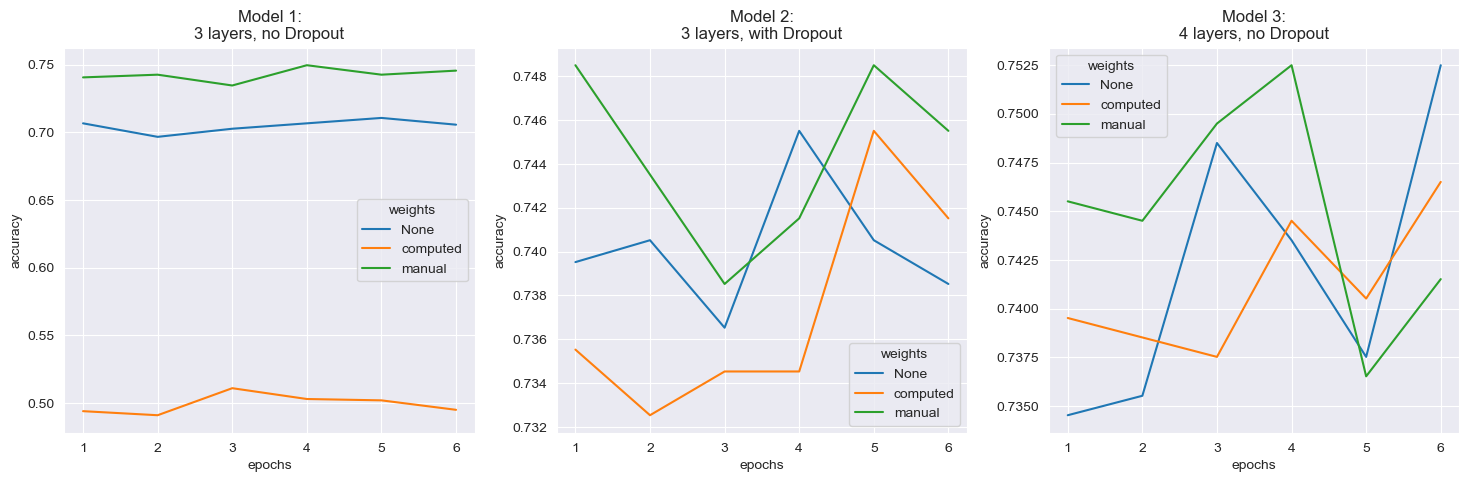

In [131]:
fig, ax = plt.subplots(ncols=3, figsize=(18,5))

sns.lineplot(data=models_results_df[models_results_df['model']=='model'],
             hue='weights',
             x='epochs',
             y='accuracy',
             ax=ax[0]
             )
ax[0].set_title('Model 1:\n3 layers, no Dropout')

sns.lineplot(data=models_results_df[models_results_df['model']=='model_2'],
             hue='weights',
             x='epochs',
             y='accuracy',
             ax=ax[1]
             )
ax[1].set_title('Model 2:\n3 layers, with Dropout')

sns.lineplot(data=models_results_df[models_results_df['model']=='model_3'],
             hue='weights',
             x='epochs',
             y='accuracy',
             ax=ax[2]
             )
ax[2].set_title('Model 3:\n4 layers, no Dropout')

plt.show()

### Training the model

In [21]:
trained_model = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights_manual
)

Epoch 1/10
226/226 [==============================] - 452s 2s/step - loss: 0.9753 - accuracy: 0.6219 - val_loss: 0.9822 - val_accuracy: 0.6750
Epoch 2/10
226/226 [==============================] - 341s 2s/step - loss: 0.8260 - accuracy: 0.6523 - val_loss: 0.8658 - val_accuracy: 0.6855
Epoch 3/10
226/226 [==============================] - 341s 2s/step - loss: 0.8010 - accuracy: 0.6567 - val_loss: 0.8618 - val_accuracy: 0.6922
Epoch 4/10
226/226 [==============================] - 337s 1s/step - loss: 0.7468 - accuracy: 0.6630 - val_loss: 0.9296 - val_accuracy: 0.6767
Epoch 5/10
226/226 [==============================] - 335s 1s/step - loss: 0.7384 - accuracy: 0.6700 - val_loss: 0.8168 - val_accuracy: 0.6811
Epoch 6/10
226/226 [==============================] - 335s 1s/step - loss: 0.6962 - accuracy: 0.6875 - val_loss: 0.8500 - val_accuracy: 0.6850
Epoch 7/10
226/226 [==============================] - 336s 1s/step - loss: 0.6708 - accuracy: 0.6963 - val_loss: 0.7984 - val_accuracy: 0.7133

In [33]:
for i in range(len(trained_model.history['loss'])):
    print(f'Epoch: {i+1}')
    loss, accuracy = model.evaluate(test_generator)
    print(f'Loss: {loss: .3f}, Accuracy: {accuracy: .3f}\n')

Epoch: 0
32/32 [==============================] - 21s 644ms/step - loss: 0.8388 - accuracy: 0.7106
Loss: 0.8388306498527527, Accuracy: 0.7105788588523865

Epoch: 1
32/32 [==============================] - 21s 642ms/step - loss: 0.8344 - accuracy: 0.7226
Loss: 0.8343892693519592, Accuracy: 0.7225548624992371

Epoch: 2
32/32 [==============================] - 22s 694ms/step - loss: 0.8397 - accuracy: 0.7136
Loss: 0.8396683931350708, Accuracy: 0.7135728597640991

Epoch: 3
32/32 [==============================] - 23s 713ms/step - loss: 0.8373 - accuracy: 0.7156
Loss: 0.8373363614082336, Accuracy: 0.7155688405036926

Epoch: 4
32/32 [==============================] - 21s 659ms/step - loss: 0.8404 - accuracy: 0.7036
Loss: 0.8403730988502502, Accuracy: 0.703592836856842

Epoch: 5
32/32 [==============================] - 22s 679ms/step - loss: 0.8425 - accuracy: 0.7126
Loss: 0.8424994349479675, Accuracy: 0.71257483959198

Epoch: 6
32/32 [==============================] - 22s 673ms/step - loss: 

### Model evaluation

In [23]:
predicted_01 = model.predict(test_generator)

32/32 [==============================] - 30s 946ms/step


In [24]:
# predicted_values_01 = np.argmax(predicted_01, axis=1)
# true_values = test_generator.classes
# confusion_mtx_01 = confusion_matrix(true_values, predicted_values_01)
# confusion_mtx_01

In [25]:
predicted_02 = model.predict(test_generator)

32/32 [==============================] - 23s 702ms/step


In [26]:
evaluated_02 = model.evaluate(test_generator)

32/32 [==============================] - 23s 703ms/step - loss: 0.8478 - accuracy: 0.7126


In [27]:
predicted_values_02 = np.argmax(predicted_02, axis=1)
true_values = test_generator.classes
confusion_mtx_02 = confusion_matrix(true_values, predicted_values_02)
confusion_mtx_02

array([[  1,   2,   1,   0,   2,  19,   0],
       [  1,   4,   5,   2,   8,  39,   2],
       [  3,   5,   9,   2,  14,  66,   2],
       [  0,   1,   0,   0,   0,   4,   0],
       [  3,   2,   6,   1,  16,  64,   0],
       [  9,  36,  56,  11,  93, 490,  12],
       [  0,   0,   1,   0,   0,  10,   0]], dtype=int64)

# Pytania

